In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import io
import zipfile
from io import BytesIO
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder, StandardScaler
import bisect

# 데이터 로드
# 특정 파일만 압축풀기
with ZipFile('../data/open.zip','r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename.endswith('.csv'):
            zipRead = zipObj.read(filename)
            globals()[f'{filename[:-4]}'] = pd.read_csv(BytesIO(zipRead))
# train.csv >> train , test.csv >> test

# 날짜 데이터 전처리
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    # ARI_CO와 ARI_PO 컬럼 병합
    df['ARI'] = df['ARI_CO']+df['ARI_PO']

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# 불필요 컬럼 제거 = 'ATA_LT','ID','SHIPMANAGER','FLAG'
train.drop(columns=['SAMPLE_ID','ATA_LT','ID','SHIPMANAGER','FLAG'], inplace=True)
test.drop(columns=['SAMPLE_ID','ATA_LT','ID','SHIPMANAGER','FLAG'], inplace=True)
# ARI_CO와 ARI_PO 컬럼 제거
train.drop(columns=['ARI_CO','ARI_PO'],axis=1,inplace=True)
test.drop(columns=['ARI_CO','ARI_PO'],axis=1,inplace=True)

# 같은 종류의 SHIP_TYPE으로 결측치 처리
Cargo_ships=train[train['SHIP_TYPE_CATEGORY']==train[train['BREADTH'].isnull()]['SHIP_TYPE_CATEGORY'].iloc[0]]
# 결측치 채우기
idx=train[train['BREADTH'].isnull()].index[0]
for df in [train,test]:
    for feature in ['BREADTH','DEADWEIGHT','DEPTH','DRAUGHT','LENGTH','GT']:
        df[feature] = df[feature].astype(float)
train.loc[idx,['BREADTH','DEADWEIGHT','DEPTH','DRAUGHT','LENGTH','GT']] = Cargo_ships[['BREADTH','DEADWEIGHT','DEPTH','DRAUGHT','LENGTH','GT']].mean().astype(float)

# ARI와 SHIP_TYPE_CATEGORY 인코딩
categorical_features = ['ARI','SHIP_TYPE_CATEGORY']
encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

In [2]:
train = train.astype(np.float32)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SHIP_TYPE_CATEGORY  391939 non-null  float32
 1   DIST                391939 non-null  float32
 2   BREADTH             391939 non-null  float32
 3   BUILT               391939 non-null  float32
 4   DEADWEIGHT          391939 non-null  float32
 5   DEPTH               391939 non-null  float32
 6   DRAUGHT             391939 non-null  float32
 7   GT                  391939 non-null  float32
 8   LENGTH              391939 non-null  float32
 9   U_WIND              228251 non-null  float32
 10  V_WIND              228251 non-null  float32
 11  AIR_TEMPERATURE     227309 non-null  float32
 12  BN                  228251 non-null  float32
 13  PORT_SIZE           391939 non-null  float32
 14  CI_HOUR             391939 non-null  float32
 15  year                391939 non-nul

In [3]:
# LabelEncoder 확인
for key in encoders.keys():
    le = encoders.get(key)
    print(key,le.classes_)

ARI ['-1' 'AUAIB7' 'AUKSF1' 'AUNQO4' 'AUPBQ1' 'AUPDL4' 'AUQGL7' 'AUTBL3'
 'AUWHH4' 'AUWXQ2' 'AUYDP4' 'BRMMW5' 'BRTMW2' 'BRVFD8' 'BRXGX5' 'CABAZ5'
 'CAFFM2' 'CAGRQ5' 'CAPUF3' 'CATYY2' 'CAXIU1' 'CLGQJ7' 'CNBGX4' 'CNEKP8'
 'CNEUC8' 'CNFTQ1' 'CNJDG8' 'CNJEN5' 'CNJTD1' 'CNNCU8' 'CNNGG6' 'CNQQW1'
 'CNRGT8' 'CNSXD2' 'CNTDA5' 'CNTXO3' 'CNUVK6' 'CNWAF5' 'CNWEY7' 'CNXVZ3'
 'CNYRT6' 'FIDEJ2' 'IDDIN2' 'IDEVL6' 'IDPPM2' 'IDREJ1' 'IDURE2' 'IDXEO4'
 'INEIA2' 'INJER7' 'INOBZ3' 'INQTU5' 'INSLZ5' 'INUJM2' 'JPCSP6' 'JPHYG5'
 'JPIEW6' 'JPLXJ7' 'JPMIA8' 'JPMOC5' 'JPOOV8' 'JPQEA4' 'JPQYY1' 'JPSPG1'
 'JPTMR7' 'JPURD4' 'JPVYJ1' 'JPZAG4' 'KRBGD2' 'KRDMD4' 'KROKM4' 'KRRKA2'
 'LVMCG4' 'LVUEW5' 'MYEFG4' 'MYLHD1' 'MZOZD2' 'MZPAF4' 'PEHYV6' 'PEYFK5'
 'PHXZF6' 'QAKIU2' 'RUAZU6' 'RUFAV3' 'RUFCD5' 'RUHGH2' 'RUNNC2' 'RUQXE2'
 'RUUPI6' 'RUVXM8' 'RUZME5' 'SGGIW5' 'TTIVU2' 'TWEKP8' 'TWJWI3' 'UACEI5'
 'UAPEL6' 'USEVX2' 'USQGN3' 'USUIR7' 'VEJEA6' 'VNJGL5' 'VNONW1' 'VNQRN3'
 'ZACXL1']
SHIP_TYPE_CATEGORY ['-1' 'Bulk' 'Cargo' 

In [4]:
# 남은 결측치 확인 >> (U_WIND, V_WIND, BN) , (AIR_TEMPERATURE)
train.isnull().sum()

SHIP_TYPE_CATEGORY         0
DIST                       0
BREADTH                    0
BUILT                      0
DEADWEIGHT                 0
DEPTH                      0
DRAUGHT                    0
GT                         0
LENGTH                     0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
PORT_SIZE                  0
CI_HOUR                    0
year                       0
month                      0
day                        0
hour                       0
ARI                        0
dtype: int64

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

#### (U_WIND, V_WIND, BN) 결측치 처리.
바람에 대한 데이터는 '지역' 및 '시간'과 관련<br/>
ARI, (year,month,day,hour) 데이터로 바람 데이터 예측하기

In [6]:
# data
wind_bn = train[['ARI','year','month','day','hour','U_WIND','V_WIND','BN']].copy()
wind_bn_ = wind_bn[wind_bn['U_WIND'].notnull()]
wind_bn_for_pred = wind_bn[wind_bn['U_WIND'].isnull()]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(wind_bn_.loc[:,['ARI','year','month','day','hour']].values)

x = scaled_data
y = wind_bn_.loc[:,['U_WIND','V_WIND','BN']].values

x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                test_size=0.3)

# Convert the data into tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# for prediction
x_test = scaler.transform(wind_bn_for_pred.loc[:,['ARI','year','month','day','hour']].values)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)

print('x_tr:',x_train_tensor.size())
print('x_tr:',y_train_tensor.size())
print('x_val:',x_val_tensor.size())
print('y_val:',y_val_tensor.size())

x_tr: torch.Size([159775, 1, 5])
x_tr: torch.Size([159775, 1, 3])
x_val: torch.Size([68476, 1, 5])
y_val: torch.Size([68476, 1, 3])


In [7]:
# Create data loaders
batch_size = 150

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Define the training parameters
input_size = x_train.shape[1]  # ARI, year, month, day, hour
hidden_size = 128
num_layers = 3
output_size = y_train.shape[1]  # U_WIND, V_WIND, BN
patience = 30
print(input_size, output_size)

5 3


In [9]:
# Define the LSTM model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
    self.fc = nn.Linear(hidden_size, output_size, bias=True)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

In [10]:
# Create the LSTM model
wind_model = LSTM(input_size, hidden_size, num_layers, output_size)

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(wind_model.parameters(),lr = 0.001)

In [12]:
wind_model.load_state_dict(torch.load('../model/best_wind_model.pth'))

<All keys matched successfully>

In [13]:
wind_model

LSTM(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [12]:
# Train the model
best_loss = float('inf')
early_stopping_counter = 0
train_losses = []
val_losses = []
epoch_counter = 0

for epoch in range(1000):
    wind_model.train()
    train_loss = 0
    
    i = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x
        batch_y = batch_y
        optimizer.zero_grad()
        output = wind_model(batch_x)
        if i == 0:
            print(output.size(), batch_y.size())
            print(output.unsqueeze(1).shape)
            i+=1
            
        loss = criterion(output.unsqueeze(1), batch_y)
        train_loss += loss.item() * batch_x.size(0)
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(average_train_loss)
        
    wind_model.eval()
    
    with torch.no_grad():
        val_loss = 0
        
        for batch_x,batch_y in val_loader: 
            batch_x = batch_x
            batch_y = batch_y
            output = wind_model(batch_x)
            loss = criterion(output.unsqueeze(1), batch_y)
            val_loss += loss.item() * batch_x.size(0)
        
        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)
        
        epoch_counter+=1
        if epoch_counter%10 == 0:
            print('Epoch: {}, train_loss: {:.4f}, val_loss: {:.4f}'.format(
                epoch_counter, average_train_loss, average_val_loss))
        
#         y_pred = wind_model(x_val_tensor)
#         y_pred = y_pred.unsqueeze(0).repeat(y_val_tensor.shape[0], 1, 1)
#         val_loss = criterion(y_pred, y_val_tensor)
        if average_val_loss < best_loss:
            best_loss = average_val_loss
            torch.save(wind_model.state_dict(), '../model/best_wind_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break

torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
Epoch: 10, train_loss: 7.4040, val_loss: 7.3714
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size

torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
Epoch: 120, train_loss: 5.9879, val_loss: 5.7465
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Siz

torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
Epoch: 230, train_loss: 5.7682, val_loss: 5.5236
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Siz

torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
Epoch: 340, train_loss: 5.6750, val_loss: 5.4326
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Siz

torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
Epoch: 450, train_loss: 5.5586, val_loss: 5.3706
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Siz

torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
Epoch: 560, train_loss: 5.5007, val_loss: 5.3477
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])
torch.Size([150, 3]) torch.Size([150, 1, 3])
torch.Size([150, 1, 3])


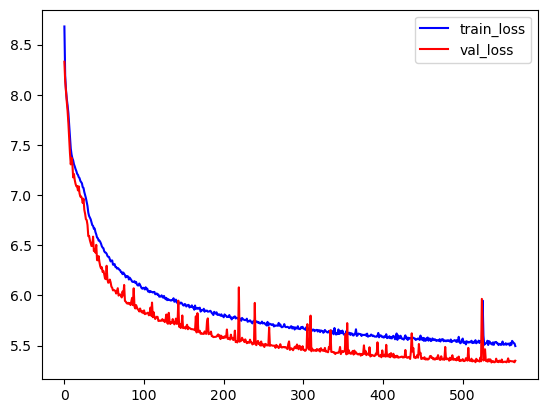

In [13]:
plt.plot(range(len(train_losses)),train_losses,color='blue',label='train_loss')
plt.plot(range(len(train_losses)),val_losses,color='red',label='val_loss')
plt.legend()
plt.show()

In [14]:
# 모델 불러오기
# wind_model.load_state_dict(torch.load('../model/best_wind_model.pth'))

In [14]:
x_test_tensor1 = x_test_tensor[:10000,:,:]
x_test_tensor2 = x_test_tensor[10000:20000,:,:]
x_test_tensor3 = x_test_tensor[20000:30000,:,:]
x_test_tensor4 = x_test_tensor[30000:40000,:,:]
x_test_tensor5 = x_test_tensor[40000:50000,:,:]
x_test_tensor6 = x_test_tensor[50000:60000,:,:]
x_test_tensor7 = x_test_tensor[60000:70000,:,:]
x_test_tensor8 = x_test_tensor[70000:80000,:,:]
x_test_tensor9 = x_test_tensor[80000:90000,:,:]
x_test_tensor10 = x_test_tensor[90000:100000,:,:]
x_test_tensor11 = x_test_tensor[100000:110000,:,:]
x_test_tensor12 = x_test_tensor[110000:120000,:,:]
x_test_tensor13 = x_test_tensor[120000:130000,:,:]
x_test_tensor14 = x_test_tensor[130000:140000,:,:]
x_test_tensor15 = x_test_tensor[140000:150000,:,:]
x_test_tensor16 = x_test_tensor[150000:160000,:,:]
x_test_tensor17 = x_test_tensor[160000:,:,:]

In [15]:
wind_pred1 =wind_model(x_test_tensor1 )
wind_pred2 =wind_model(x_test_tensor2 )
wind_pred3 =wind_model(x_test_tensor3 )
wind_pred4 =wind_model(x_test_tensor4 )
wind_pred5 =wind_model(x_test_tensor5 )
wind_pred6 =wind_model(x_test_tensor6 )
wind_pred7 =wind_model(x_test_tensor7 )
wind_pred8 =wind_model(x_test_tensor8 )
wind_pred9 =wind_model(x_test_tensor9 )
wind_pred10 =wind_model(x_test_tensor10)
wind_pred11 =wind_model(x_test_tensor11)
wind_pred12 =wind_model(x_test_tensor12)
wind_pred13 =wind_model(x_test_tensor13)
wind_pred14 =wind_model(x_test_tensor14)
wind_pred15 =wind_model(x_test_tensor15)
wind_pred16 =wind_model(x_test_tensor16)
wind_pred17 =wind_model(x_test_tensor17)

In [16]:
wind_pred = torch.cat((wind_pred1,wind_pred2,wind_pred3,
          wind_pred4,wind_pred5,wind_pred6,wind_pred7,
          wind_pred8,wind_pred9,wind_pred10,wind_pred11,
          wind_pred12,wind_pred13,wind_pred14,wind_pred15,
          wind_pred16,wind_pred17),dim=0).detach()
wind_pred.size()

torch.Size([163688, 3])

In [17]:
wind_pred_df = pd.DataFrame(data=wind_pred.detach().numpy(),index=wind_bn_for_pred.index,columns=['U_WIND','V_WIND','BN'])
wind_pred_df.head()

,U_WIND,V_WIND,BN
0,-1.070771,-2.912719,1.263408
1,1.941282,-0.137933,1.265157
2,-1.747245,0.077305,3.347121
6,0.117167,-1.272008,2.761451
8,0.820990,0.168441,1.958429


In [18]:
train_w = train.copy()
train_w.loc[wind_bn_for_pred.index,['U_WIND','V_WIND','BN']]=wind_pred_df

In [19]:
train_w

,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,PORT_SIZE,CI_HOUR,year,month,day,hour,ARI
0,2.0,30.881018,30.0,24.0,24300.0,10.0,10.0,16700.0,180.0,-1.070771,-2.912719,NaN,1.263408,0.002615,3.450000,2018.0,12.0,17.0,21.0,90.0
1,0.0,0.000000,30.0,13.0,35900.0,10.0,10.0,23500.0,180.0,1.941282,-0.137933,NaN,1.265157,0.000217,0.000000,2014.0,9.0,23.0,6.0,52.0
2,2.0,0.000000,50.0,12.0,146000.0,30.0,20.0,140000.0,370.0,-1.747245,0.077305,NaN,3.347121,0.001614,0.000000,2015.0,2.0,3.0,22.0,23.0
3,2.0,0.000000,20.0,18.0,6910.0,10.0,10.0,5400.0,120.0,-3.180000,-1.610000,6.700000,2.629350,0.000356,0.000000,2020.0,1.0,17.0,4.0,66.0
4,2.0,27.037651,50.0,10.0,116000.0,20.0,10.0,96600.0,300.0,-0.330000,-3.280000,25.600000,2.495953,0.002615,253.554443,2020.0,1.0,26.0,7.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,2.0,0.000000,20.0,27.0,6820.0,10.0,10.0,4820.0,110.0,0.473672,0.255533,NaN,0.391919,0.000552,0.000000,2017.0,6.0,6.0,5.0,61.0
391935,0.0,5.884603,10.0,12.0,3160.0,10.0,10.0,1600.0,80.0,-0.660000,0.970000,27.299999,1.253491,0.002615,144.061386,2019.0,10.0,16.0,0.0,90.0
391936,0.0,70.660240,30.0,8.0,60300.0,20.0,10.0,34800.0,200.0,-3.440000,7.990000,21.100000,4.766257,0.000155,41.482224,2021.0,3.0,23.0,22.0,97.0
391937,2.0,9.448179,30.0,29.0,23800.0,10.0,10.0,16900.0,170.0,-1.066123,-0.496618,NaN,-0.166806,0.000990,7.485278,2015.0,1.0,8.0,7.0,93.0


#### AIR_TEMPERATURE 결측치 처리

In [20]:
# data
air = train[['ARI','year','month','day','hour','AIR_TEMPERATURE']].copy()
air_ = air[air['AIR_TEMPERATURE'].notnull()]
air_for_pred = air[air['AIR_TEMPERATURE'].isnull()]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(air_.loc[:,['ARI','year','month','day','hour']].values)

x = scaled_data
y = air_.loc[:,['AIR_TEMPERATURE']].values

x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                test_size=0.3)

# Convert the data into tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# for prediction
x_test = scaler.transform(air_for_pred.loc[:,['ARI','year','month','day','hour']].values)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)

print('x_tr:',x_train_tensor.size())
print('x_tr:',y_train_tensor.size())
print('x_val:',x_val_tensor.size())
print('y_val:',y_val_tensor.size())

x_tr: torch.Size([159116, 1, 5])
x_tr: torch.Size([159116, 1, 1])
x_val: torch.Size([68193, 1, 5])
y_val: torch.Size([68193, 1, 1])


In [21]:
# Create data loaders
batch_size = 150

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
# Define the training parameters
input_size = x_train.shape[1]  # ARI, year, month, day, hour
hidden_size = 128
num_layers = 3
output_size = y_train.shape[1] # AIR_TEMPERATURE
patience = 30
print(input_size, output_size)

5 1


In [23]:
# Create the LSTM model
air_model = LSTM(input_size, hidden_size, num_layers, output_size)

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(air_model.parameters(),lr = 0.003)

In [25]:
air_model.load_state_dict(torch.load('../model/best_air_model.pth'))

<All keys matched successfully>

In [26]:
# Train the model
best_loss = float('inf')
early_stopping_counter = 0
train_losses = []
val_losses = []
epoch_counter = 0

for epoch in range(500):
    air_model.train()
    train_loss = 0
    
#     i = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x
        batch_y = batch_y
        optimizer.zero_grad()
        output = air_model(batch_x)
#         if i == 0:
#             print(output.size(), batch_y.size())
#             print(output.unsqueeze(1).shape)
#             i+=1
            
        loss = criterion(output.unsqueeze(1), batch_y)
        train_loss += loss.item() * batch_x.size(0)
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(average_train_loss)
        
    air_model.eval()
    
    with torch.no_grad():
        val_loss = 0
        
        for batch_x,batch_y in val_loader: 
            batch_x = batch_x
            batch_y = batch_y
            output = air_model(batch_x)
            loss = criterion(output.unsqueeze(1), batch_y)
            val_loss += loss.item() * batch_x.size(0)
        
        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)
        
        epoch_counter+=1
        if epoch_counter%10 == 0:
            print('Epoch: {}, train_loss: {:.4f}, val_loss: {:.4f}'.format(
                epoch_counter, average_train_loss, average_val_loss))
        
        if average_val_loss < best_loss:
            best_loss = average_val_loss
            torch.save(air_model.state_dict(), '../model/best_air_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break

Epoch: 10, train_loss: 23.9690, val_loss: 20.7877
Epoch: 20, train_loss: 21.4736, val_loss: 18.5411
Epoch: 30, train_loss: 20.7023, val_loss: 17.9321
Epoch: 40, train_loss: 19.8819, val_loss: 18.2012
Epoch: 50, train_loss: 19.1445, val_loss: 16.6712
Epoch: 60, train_loss: 17.9597, val_loss: 16.0984
Epoch: 70, train_loss: 17.6677, val_loss: 17.8608
Epoch: 80, train_loss: 17.2613, val_loss: 14.8959
Epoch: 90, train_loss: 17.4567, val_loss: 15.4093
Epoch: 100, train_loss: 17.1585, val_loss: 14.9856
Epoch: 110, train_loss: 16.5480, val_loss: 14.9454
Epoch: 120, train_loss: 16.8722, val_loss: 14.6689
Epoch: 130, train_loss: 16.3632, val_loss: 14.2575
Epoch: 140, train_loss: 16.4237, val_loss: 14.1801
Epoch: 150, train_loss: 16.5118, val_loss: 14.3610
Epoch: 160, train_loss: 16.1111, val_loss: 14.3029
Epoch: 170, train_loss: 16.5328, val_loss: 14.5307
Epoch: 180, train_loss: 15.6526, val_loss: 14.2993
Epoch: 190, train_loss: 15.5035, val_loss: 14.0633
Epoch: 200, train_loss: 14.9870, val_los

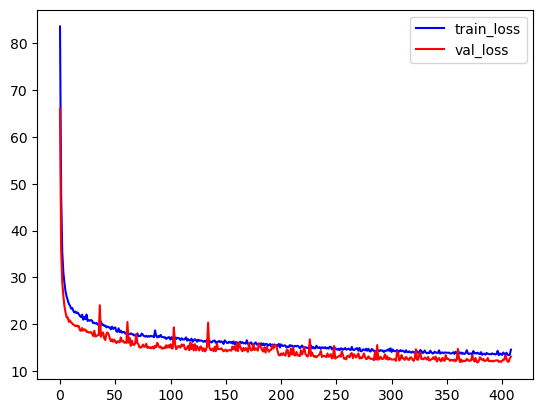

In [27]:
plt.plot(range(len(train_losses)),train_losses,color='blue',label='train_loss')
plt.plot(range(len(train_losses)),val_losses,color='red',label='val_loss')
plt.legend()
plt.show()

In [26]:
x_test_tensor1 = x_test_tensor[:10000,:,:]
x_test_tensor2 = x_test_tensor[10000:20000,:,:]
x_test_tensor3 = x_test_tensor[20000:30000,:,:]
x_test_tensor4 = x_test_tensor[30000:40000,:,:]
x_test_tensor5 = x_test_tensor[40000:50000,:,:]
x_test_tensor6 = x_test_tensor[50000:60000,:,:]
x_test_tensor7 = x_test_tensor[60000:70000,:,:]
x_test_tensor8 = x_test_tensor[70000:80000,:,:]
x_test_tensor9 = x_test_tensor[80000:90000,:,:]
x_test_tensor10 = x_test_tensor[90000:100000,:,:]
x_test_tensor11 = x_test_tensor[100000:110000,:,:]
x_test_tensor12 = x_test_tensor[110000:120000,:,:]
x_test_tensor13 = x_test_tensor[120000:130000,:,:]
x_test_tensor14 = x_test_tensor[130000:140000,:,:]
x_test_tensor15 = x_test_tensor[140000:150000,:,:]
x_test_tensor16 = x_test_tensor[150000:160000,:,:]
x_test_tensor17 = x_test_tensor[160000:,:,:]
air_pred1 = air_model(x_test_tensor1 )
air_pred2 = air_model(x_test_tensor2 )
air_pred3 = air_model(x_test_tensor3 )
air_pred4 = air_model(x_test_tensor4 )
air_pred5 = air_model(x_test_tensor5 )
air_pred6 = air_model(x_test_tensor6 )
air_pred7 = air_model(x_test_tensor7 )
air_pred8 = air_model(x_test_tensor8 )
air_pred9 = air_model(x_test_tensor9 )
air_pred10 = air_model(x_test_tensor10)
air_pred11 = air_model(x_test_tensor11)
air_pred12 = air_model(x_test_tensor12)
air_pred13 = air_model(x_test_tensor13)
air_pred14 = air_model(x_test_tensor14)
air_pred15 = air_model(x_test_tensor15)
air_pred16 = air_model(x_test_tensor16)
air_pred17 = air_model(x_test_tensor17)
air_pred = torch.cat((air_pred1,air_pred2,air_pred3,
          air_pred4,air_pred5,air_pred6,air_pred7,
          air_pred8,air_pred9,air_pred10,air_pred11,
          air_pred12,air_pred13,air_pred14,air_pred15,
          air_pred16,air_pred17),dim=0).detach()
air_pred.size()

torch.Size([164630, 1])

In [27]:
air_pred_df = pd.DataFrame(data=air_pred.numpy(),index=air_for_pred.index,columns=['AIR_TEMPERATURE'])
train_fillna = train_w.copy()
train_fillna.loc[air_for_pred.index,['AIR_TEMPERATURE']]=air_pred_df

In [28]:
print('결측값 개수 : ',train_fillna.isnull().sum().sum())

결측값 개수 :  0


<hr/>

### Train

In [30]:
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

Model Tune for LGBM.


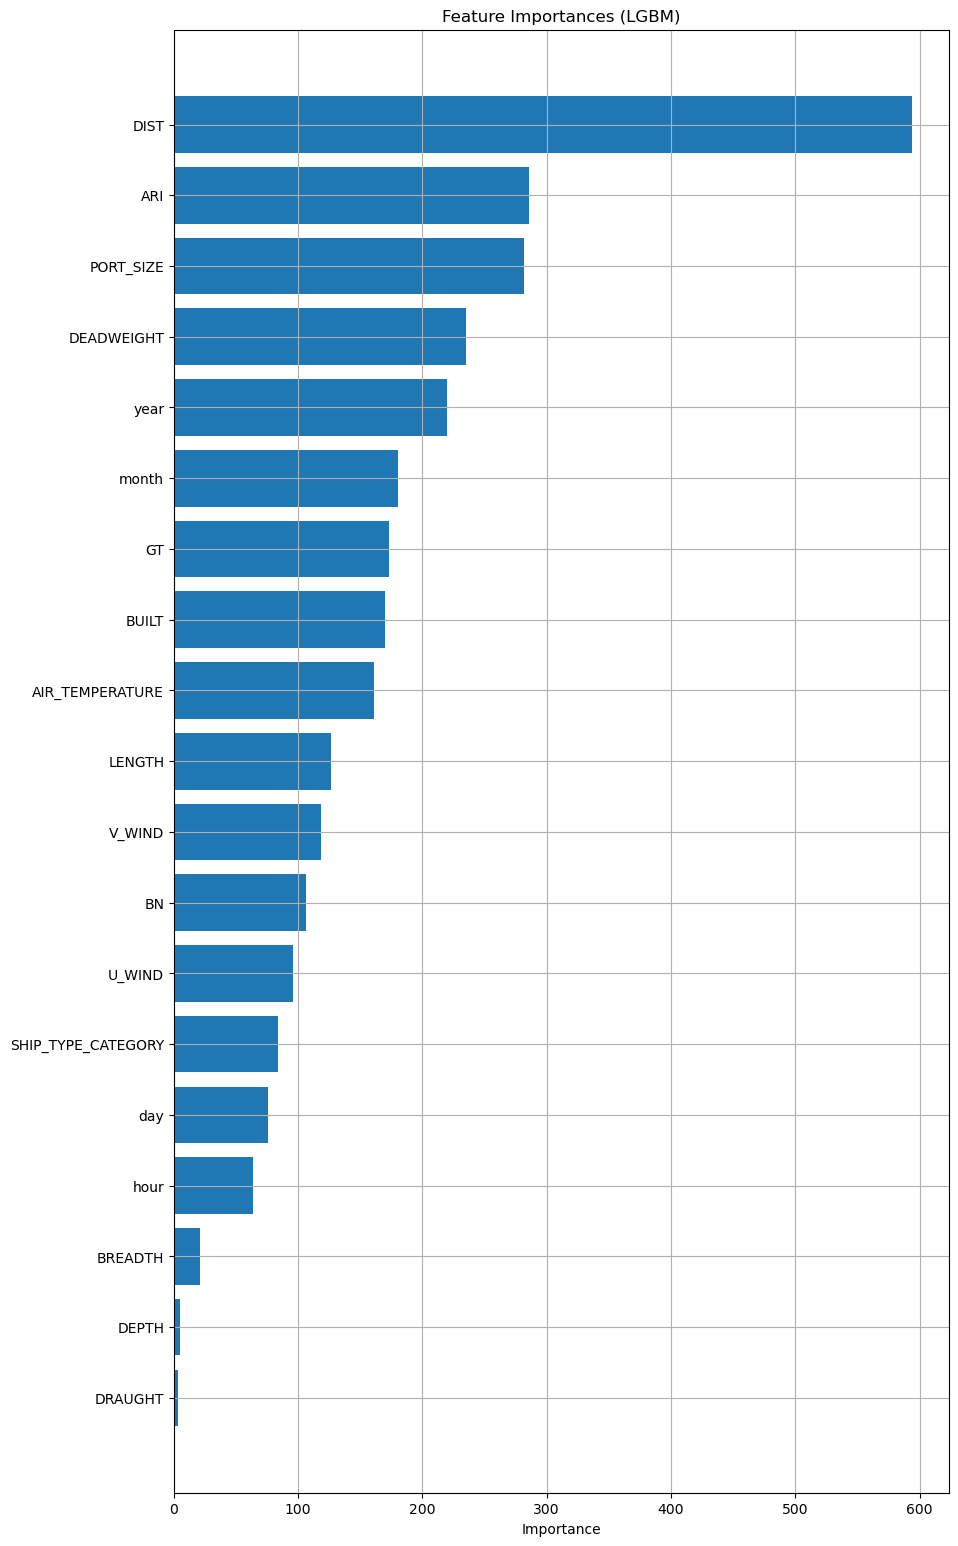

In [31]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.grid()
    plt.show()
    
    return model, feature_importances

X_train = train_fillna.drop(columns='CI_HOUR')
y_train = train_fillna['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

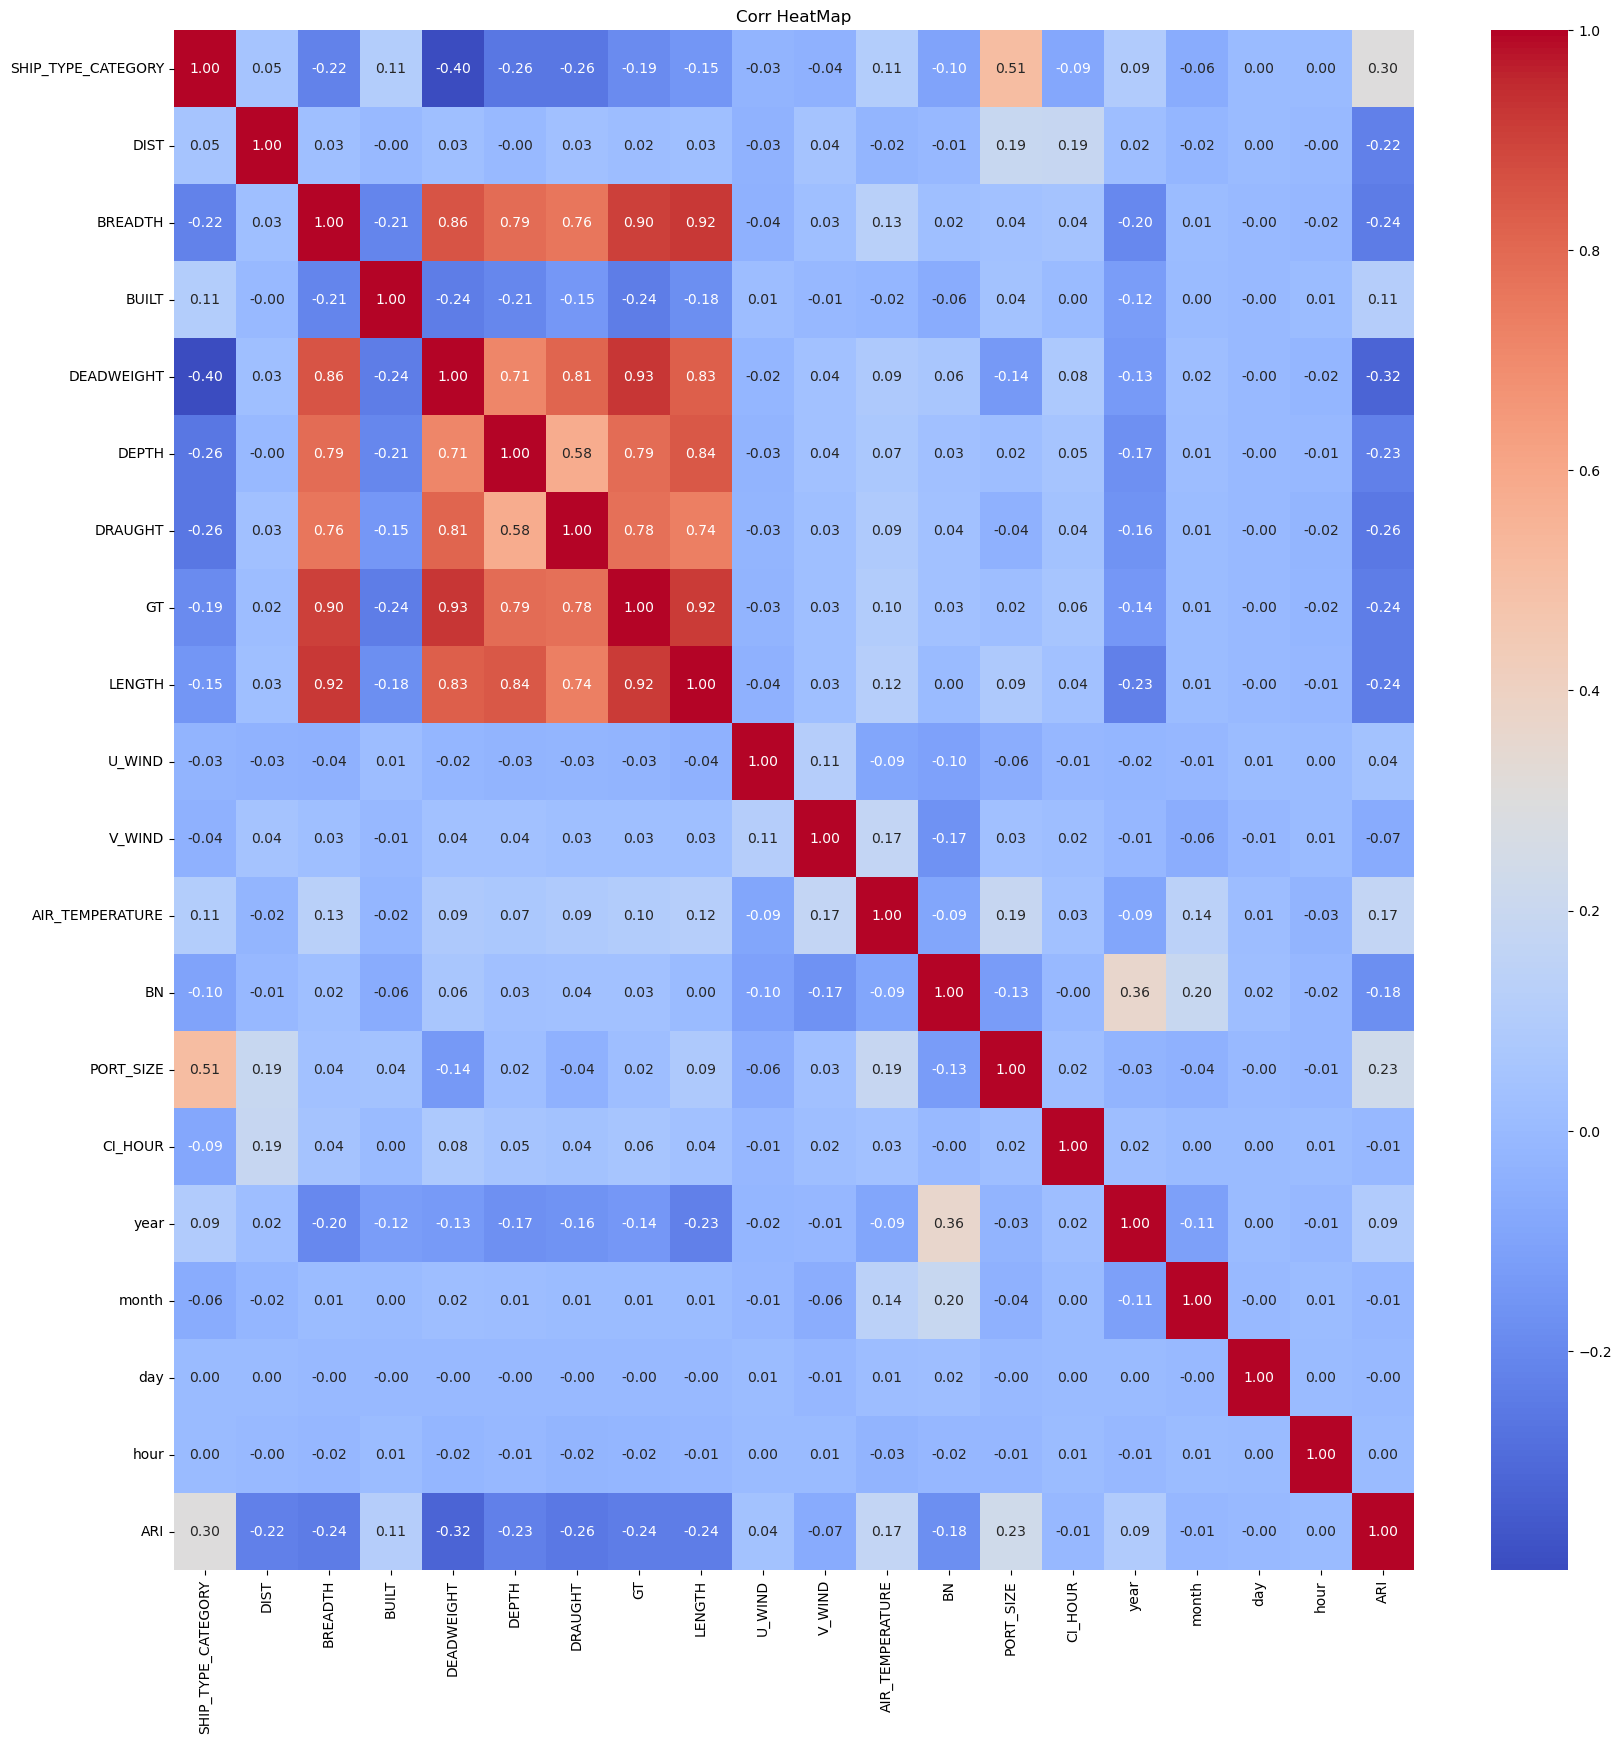

In [84]:
import seaborn as sns
# df로부터 '상관계수 행렬'을 구한다.
train_correlation_matrix = train_fillna.corr()
# 상관관계를 시각화한다.
plt.figure(figsize=(20, 20))
sns.heatmap(train_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corr HeatMap")
plt.savefig('HD_ship_Corr.png',dpi=300)
plt.show()

In [33]:
# MinMaxScale
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
mmses = {}
train_fillna_scaled = train_fillna.copy()
for colname in train_fillna.columns:
    if colname == 'CI_HOUR':
        continue
    mms = MinMaxScaler()
    poly = PolynomialFeatures(degree=2, include_bias=False)
    train_fillna_scaled[colname] = mms.fit_transform(train_fillna[colname].values.reshape(-1,1))
    mmses[colname] = mms



C:\Users\songkyu\AppData\Local\Temp\ipykernel_13240\1011190601.py:17: RuntimeWarning: divide by zero encountered in log1p
  train_fillna_scaled[col] = np.log1p(train_fillna[col].values)
C:\Users\songkyu\AppData\Local\Temp\ipykernel_13240\1011190601.py:17: RuntimeWarning: invalid value encountered in log1p
  train_fillna_scaled[col] = np.log1p(train_fillna[col].values)


In [118]:
X_train = train_fillna_scaled.drop(columns='CI_HOUR')
y_train = train_fillna_scaled['CI_HOUR']

In [119]:
threshold = 80 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

high_corr = ['BREADTH','DEPTH','DRAUGHT','hour']
X_train_reduced = X_train.drop(columns=high_corr)
X_test_reduced = test.drop(columns=high_corr)

In [120]:
X_train_reduced.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'BUILT', 'DEADWEIGHT', 'GT', 'LENGTH',
       'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'PORT_SIZE', 'year',
       'month', 'day', 'ARI'],
      dtype='object')

In [44]:
class Feedforward(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Feedforward, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Linear(input_dim, 64, bias = True),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Linear(64,128, bias = True)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(128,1, bias = True)
        
    def forward(self, x):
        x = self.seq1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
        

In [53]:
X_train_reduced_tensor = torch.tensor(X_train_reduced.values, dtype=torch.float32).unsqueeze(1)
y_cih_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).unsqueeze(1)
X_test_reduced_tensor = torch.tensor(X_test_reduced.values, dtype = torch.float32)

xtrt_tr = X_train_reduced_tensor[:301939,:,:]
xtrt_val = X_train_reduced_tensor[301939:,:,:]
yt_tr = y_cih_train_tensor[:301939,:,:]
yt_val = y_cih_train_tensor[301939:,:,:]


batch_size = 150

X_train_reduced_dataset = TensorDataset(xtrt_tr, yt_tr)
X_train_reduced_loader = DataLoader(X_train_reduced_dataset, batch_size=batch_size, shuffle=True)
X_val_reduced_dataset = TensorDataset(xtrt_val, yt_val)
X_val_reduced_loader = DataLoader(X_val_reduced_dataset, batch_size=batch_size, shuffle=False)

X_test_reduced_dataset = TensorDataset(X_test_reduced_tensor)

In [54]:
input_dim = X_train_reduced.shape[1]
output_dim = 1
patience = 30

In [55]:
final_model = Feedforward(input_dim, output_dim)
final_model

Feedforward(
  (seq1): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [56]:
fin_criterion = nn.MSELoss()
fin_optimizer = optim.Adam(final_model.parameters(), lr=0.001, betas=(0.5,0.999))

In [57]:
# Train the model
best_loss = float('inf')
early_stopping_counter = 0
train_losses = []
val_losses = []
epoch_counter = 0

for epoch in range(500):
    final_model.train()
    train_loss = 0
    
    i = 0
    for batch_x, batch_y in X_train_reduced_loader:
        batch_x = batch_x
        batch_y = batch_y
#         print(batch_x.size(), batch_y.size())
        fin_optimizer.zero_grad()
        output = final_model(batch_x)
        if i == 0:
            print(output.size(), batch_y.size())
            print(output.unsqueeze(1).shape)
            i+=1
            
        loss = fin_criterion(output, batch_y)
        train_loss += loss.item() * batch_x.size(0)
        loss.backward()
        fin_optimizer.step()

    average_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(average_train_loss)
        
    final_model.eval()
    
    with torch.no_grad():
        val_loss = 0
        
        for batch_x,batch_y in X_val_reduced_loader: 
            batch_x = batch_x
            batch_y = batch_y
            output = final_model(batch_x)
            loss = fin_criterion(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)
        
        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)
        
        epoch_counter+=1
        if epoch_counter%10 == 0:
            print('Epoch: {}, train_loss: {:.4f}, val_loss: {:.4f}'.format(
                epoch_counter, average_train_loss, average_val_loss))
        
        if average_val_loss < best_loss:
            best_loss = average_val_loss
            torch.save(air_model.state_dict(), '../model/best_air_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break

torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
Epoch: 10, train_loss: 0.0094, val_loss: 0.0067
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torc

torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
Epoch: 110, train_loss: 0.0083, val_loss: 0.0065
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
torch.Size([150, 1, 1, 1])
torch.Size([150, 1, 1]) torch.Size([150, 1, 1])
tor

In [131]:
lgbm = lgb.LGBMRegressor(boosting_type='goss',learning_rate=0.03,
                        n_estimators=1000)

In [132]:
# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds: 100%|██████████████████████████████████████████| 5/5 [00:36<00:00,  7.31s/it]

Validation : MAE scores for each fold: [54.52839392616419, 55.75763942547905, 55.660134762402386, 54.82355991319352, 54.823485262433024]
Validation : MAE: 55.11864265793444


---

### Prediction

In [35]:
test.isnull().sum()

SHIP_TYPE_CATEGORY        0
DIST                      0
BREADTH                   0
BUILT                     0
DEADWEIGHT                0
DEPTH                     0
DRAUGHT                   0
GT                        0
LENGTH                    0
U_WIND                91725
V_WIND                91725
AIR_TEMPERATURE       92246
BN                    91725
PORT_SIZE                 0
year                      0
month                     0
day                       0
hour                      0
ARI                       0
dtype: int64

In [133]:
test_wind_na = test[test['U_WIND'].isnull()].copy()
test_air_na = test[test['AIR_TEMPERATURE'].isnull()].copy()

test_wind_na_x = test_wind_na.drop(['U_WIND','V_WIND','BN'],axis=1)
test_air_na_x = test_air_na.drop(['AIR_TEMPERATURE'],axis=1)

test_wind_na_x = scaler.transform(test_wind_na_x[['ARI','year','month','day','hour']].values)
test_air_na_x = scaler.transform(test_air_na_x[['ARI','year','month','day','hour']].values)

twx_tensor = torch.tensor(test_wind_na_x, dtype=torch.float32).unsqueeze(1)
tax_tensor = torch.tensor(test_air_na_x, dtype=torch.float32).unsqueeze(1)

tw_pred = wind_model(twx_tensor)
ta_pred = air_model(tax_tensor)
tw_pred.detach_()
ta_pred.detach_()

tw_pred_df = pd.DataFrame(data=tw_pred.numpy(),index=test_wind_na.index,columns=['U_WIND','V_WIND','BN'])
ta_pred_df = pd.DataFrame(data=ta_pred.numpy(),index=test_air_na.index,columns=['AIR_TEMPERATURE'])

In [123]:
test_fillna = test.copy()
test_fillna.loc[test_wind_na.index,['U_WIND','V_WIND','BN']] = tw_pred_df
test_fillna.loc[test_air_na.index,['AIR_TEMPERATURE']] = ta_pred_df

In [124]:
test_fillna.isnull().sum().sum()

0

In [134]:
test_fill_reduced = test_fillna.drop(columns=low_importance_features)
test_fill_reduced = test_fillna.drop(columns=high_corr)

In [126]:
for key in mmses.keys():
    print(key)

SHIP_TYPE_CATEGORY
DIST
BREADTH
BUILT
DEADWEIGHT
DEPTH
DRAUGHT
GT
LENGTH
U_WIND
V_WIND
AIR_TEMPERATURE
BN
PORT_SIZE
year
month
day
hour
ARI


In [135]:
# Scale
test_fill_reduced_scaled = test_fill_reduced.copy()
for key in mmses.keys():
    if key in test_fill_reduced.columns:
        test_fill_reduced_scaled[key] = mmses[key].transform(test_fill_reduced[key].values.reshape(-1,1))

In [71]:
# tensor
test_fill_reduced_scaled_tensor = torch.tensor(test_fill_reduced_scaled.values,dtype=torch.float32).unsqueeze(1)
test_fill_reduced_scaled_tensor.size()

torch.Size([220491, 1, 14])

In [136]:
# final_pred = final_model(test_fill_reduced_scaled_tensor)
# final_pred
final_pred = lgbm.predict(test_fill_reduced_scaled)
final_pred

array([124.03461199,  39.7801922 , 181.54863104, ...,  60.91187428,
        -3.2936336 , 214.20131661])

In [129]:
# final_pred_ = final_pred.squeeze(1).detach().numpy()
# final_pred_unscaled = mmses['CI_HOUR'].inverse_transform(final_pred_)
# final_pred_unscaled

# final_pred_unscaled = mmses['CI_HOUR'].inverse_transform(final_pred.reshape(-1,1))
final_pred_unscaled

KeyError: 'CI_HOUR'

In [137]:
sample = pd.read_csv('../data/sample_submission.csv')
# sample['CI_HOUR'] = pd.Series(final_pred_unscaled.reshape(-1))
sample['CI_HOUR'] = pd.Series(final_pred.reshape(-1))
sample = sample.set_index('SAMPLE_ID')
sample

,CI_HOUR
SAMPLE_ID,
TEST_000000,124.034612
TEST_000001,39.780192
TEST_000002,181.548631
TEST_000003,145.871049
TEST_000004,8.296608
...,...
TEST_220486,162.154291
TEST_220487,121.086226
TEST_220488,60.911874


In [138]:
sample.to_csv('../data/seventh_submit.csv')